In [1]:
import warnings
import os
import logging
import sys

# Βελτίωση των εκτυπώσεων
warnings.filterwarnings("ignore", category=FutureWarning)
os.environ['PYTHONWARNINGS'] = 'ignore'
logging.getLogger("xgboost").setLevel(logging.WARNING)
sys.stdout.flush()

In [2]:
from babel.util import distinct
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import min, max, mean
from pyspark.sql.functions import when, col
import numpy as np
from pyspark.ml.feature import StringIndexerModel, VectorAssembler
from pyspark.sql.functions import col, lit
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, OneVsRest, GBTClassifier
from pyspark.ml.classification import  NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
from pyspark.sql.functions import col, countDistinct
from pyspark.sql.functions import date_format
from pyspark.storagelevel import StorageLevel
import psutil
import time
import threading
import builtins
from xgboost.spark import SparkXGBClassifier
from pyspark.sql.types import DoubleType
from imblearn.over_sampling import SMOTE
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler

In [3]:
spark = SparkSession.builder.appName("Drought_NEW") \
    .master("local[*]") \
    .config("spark.executor.memory", "10g") \
    .config("spark.driver.memory", "10g") \
    .config("spark.memory.fraction", "0.9") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

25/04/08 17:27:48 WARN Utils: Your hostname, dgour-HP-Laptop-15-db1xxx resolves to a loopback address: 127.0.1.1; using 192.168.1.56 instead (on interface wlo1)
25/04/08 17:27:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/08 17:27:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
full_data = spark.read.csv("train_timeseries.csv", header=True, inferSchema=True)

In [5]:
full_data = full_data.sample(fraction=0.01, seed=42)

In [6]:
# Στήλη score:Μετατροπή των NULL τιμών σε 0.0
full_data = full_data.withColumn("score", when(col("score").isNull(), 0.0).otherwise(col("score")))

# Multi-class Classification: Μετατροπή του score σε κατηγορίες(None, D0-D4)
full_data = full_data.withColumn(
    "Label",
    when(col("score") == 0.0, "None")
    .when((col("score") > 0.0) & (col("score") < 1.0), "D0")
    .when((col("score") >= 1.0) & (col("score") < 2.0), "D1")
    .when((col("score") >= 2.0) & (col("score") < 3.0), "D2")
    .when((col("score") >= 3.0) & (col("score") < 4.0), "D3")
    .when((col("score") >= 4.0) & (col("score") <= 5.0), "D4")
)

#Μετατροπή datatype ημερομηνίας:date->int
full_data = full_data.withColumn("date", date_format(col("date"), "yyyyMMdd").cast("int"))

labels_order = ["None", "D0", "D1", "D2", "D3", "D4"]  # Ορίζουμε ότι None=0, D0=1, D1=2, ...

# Μετατροπή της κατηγορικής μεταβλητής Label σε αριθμητική(0,1,2,3,4,5)
indexer = StringIndexerModel.from_labels(labels_order, inputCol="Label", outputCol="LabelIndex")

if 'LabelIndex' in full_data.columns:
    full_data = full_data.drop('LabelIndex')

full_data = indexer.transform(full_data)

feature_cols = ["fips", "date", "PRECTOT", "PS", "QV2M", "T2M",
                "T2MDEW", "T2MWET", "T2M_MAX", "T2M_MIN",
                "T2M_RANGE", "TS", "WS10M", "WS10M_MAX",
                "WS10M_MIN", "WS10M_RANGE", "WS50M",
                "WS50M_MAX", "WS50M_MIN", "WS50M_RANGE"]

# Τα features σε μορφή διανύσματος (Vector)
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Z-score κανονικοποίηση
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

pipeline = Pipeline(stages=[
    assembler,
    scaler
])

# Fit και Transform
pipeline_model = pipeline.fit(full_data)
full_data = pipeline_model.transform(full_data)

# Τελική επιλογή στηλών
final_data = full_data.select("scaled_features", "LabelIndex")

In [7]:
# Ορισμός κλάσης για την παρακολούθηση των τιμών των υπολογιστικών πόρων(CPU, memory, Disk I/O)

class ResourceMonitorListener:
    def __init__(self):
        self.cpu_percentages = []
        self.mem_percentages = []
        self.disk_reads = []
        self.disk_writes = []
        self.monitoring = False

    def start_monitoring(self):
        self.monitoring = True
        self.cpu_percentages = []
        self.mem_percentages = []
        self.disk_reads = [psutil.disk_io_counters().read_bytes]
        self.disk_writes = [psutil.disk_io_counters().write_bytes]

        # Δημιουργία thread: κάθε 1 δευτερόλεπτο ενημερώνει τις λίστες που περιέχουν τις τιμές των πόρων
        def monitor_loop():
            while self.monitoring:
                self.cpu_percentages.append(psutil.cpu_percent(interval=1))
                self.mem_percentages.append(psutil.virtual_memory().percent)
                disk_io = psutil.disk_io_counters()
                self.disk_reads.append(disk_io.read_bytes)
                self.disk_writes.append(disk_io.write_bytes)

        self.monitor_thread = threading.Thread(target=monitor_loop, daemon=True)
        self.monitor_thread.start()

    # Διακοπή του thread 
    def stop_monitoring(self):
        self.monitoring = False
        self.monitor_thread.join()

        self.disk_reads = [x for x in self.disk_reads if isinstance(x, (int, float))]
        self.disk_writes = [x for x in self.disk_writes if isinstance(x, (int, float))]

        # Υπολογισμός των τελικών τιμών
        cpu_avg = sum(self.cpu_percentages) / len(self.cpu_percentages) if self.cpu_percentages else 0
        mem_avg = sum(self.mem_percentages) / len(self.mem_percentages) if self.mem_percentages else 0

        # Χρήση των ενσωματωμένων max/min της Python(και όχι του PySpark)
        disk_read_mb = ((builtins.max(self.disk_reads) - builtins.min(self.disk_reads)) / (1024 * 1024)) if self.disk_reads else 0
        disk_write_mb = ((builtins.max(self.disk_writes) - builtins.min(self.disk_writes)) / (1024 * 1024)) if self.disk_writes else 0

        # Επιστρέφει ένα λεξικό που περιέχει τις μετρήσεις
        return {
            "cpu_usage": cpu_avg,
            "mem_usage": mem_avg,
            "disk_read_mb": disk_read_mb,
            "disk_write_mb": disk_write_mb
        }

Το dataset αποτελείται από 193637 γραμμές.


final_data έχει 193637 γραμμές
Training with 10.0% of data

Training XGBoost...


2025-04-08 17:30:33,530 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 4 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'num_class': 6, 'nthread': 1}
	train_call_kwargs_params: {'num_boost_round': 100, 'verbose_eval': True}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-04-08 17:30:39,316 INFO XGBoost-PySpark: _train_booster Training on CPUs 4]
[17:30:40] Task 1 got rank 1[17:30:40] Task 2 got rank 2

[17:30:40] Task 0 got rank 0[17:30:40] Task 3 got rank 3

2025-04-08 17:30:56,492 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2025-04-08 17:31:01,956 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-08 17:31:04,342 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-08 17:31:05,162 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-08 17:31:06,260 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs



XGBoost (Data Size: 10.0%)
Accuracy: 0.8845
Precision: 0.8773
Recall: 0.8845
F1 Score: 0.8809
Training Time: 26.47 sec - Inference Latency: 0.21 sec
*Training* CPU: 44.94% | Memory: 78.02%
*Training* Disk Read: 127.58 MB | Write: 264.27 MB
*Inference* CPU: 24.90% | Memory: 79.40%
*Inference* Disk Read: 0.53 MB | Write: 0.20 MB


2025-04-08 17:31:07,021 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


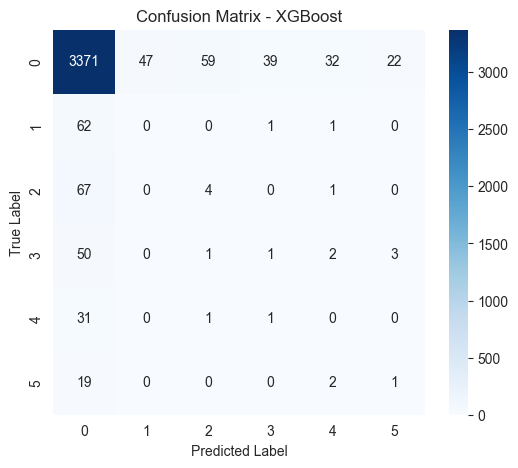

Training with 25.0% of data

Training XGBoost...


2025-04-08 17:31:25,741 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 4 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'num_class': 6, 'nthread': 1}
	train_call_kwargs_params: {'num_boost_round': 100, 'verbose_eval': True}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-04-08 17:31:26,889 INFO XGBoost-PySpark: _train_booster Training on CPUs 8]
[17:31:27] Task 1 got rank 1                                        (0 + 4) / 4]
[17:31:27] Task 2 got rank 2
[17:31:27] Task 0 got rank 0
[17:31:27] Task 3 got rank 3
2025-04-08 17:31:50,081 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2025-04-08 17:31:54,778 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-08 17:31:55,710 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-08 17:31:56,526 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-08 17:31:57,209 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs



XGBoost (Data Size: 25.0%)
Accuracy: 0.8607
Precision: 0.8759
Recall: 0.8607
F1 Score: 0.8680
Training Time: 26.80 sec - Inference Latency: 0.16 sec
*Training* CPU: 48.01% | Memory: 90.45%
*Training* Disk Read: 23.78 MB | Write: 114.51 MB
*Inference* CPU: 5.40% | Memory: 90.90%
*Inference* Disk Read: 0.00 MB | Write: 0.00 MB


2025-04-08 17:31:57,948 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


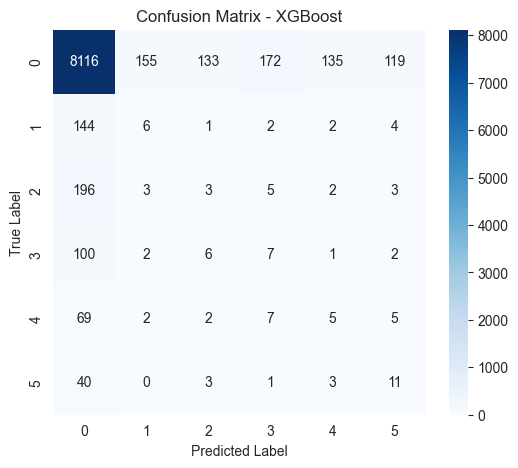

Training with 50.0% of data

Training XGBoost...


2025-04-08 17:32:26,896 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 4 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'num_class': 6, 'nthread': 1}
	train_call_kwargs_params: {'num_boost_round': 100, 'verbose_eval': True}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-04-08 17:32:28,616 INFO XGBoost-PySpark: _train_booster Training on CPUs 8]
[17:32:29] Task 2 got rank 2                                        (0 + 4) / 4]
[17:32:29] Task 1 got rank 1
[17:32:29] Task 3 got rank 3
[17:32:29] Task 0 got rank 0
2025-04-08 17:33:04,441 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2025-04-08 17:33:09,697 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-08 17:33:10,633 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-08 17:33:11,512 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-08 17:33:12,499 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs



XGBoost (Data Size: 50.0%)
Accuracy: 0.8617
Precision: 0.8832
Recall: 0.8617
F1 Score: 0.8720
Training Time: 39.40 sec - Inference Latency: 0.14 sec
*Training* CPU: 50.17% | Memory: 92.68%
*Training* Disk Read: 13.81 MB | Write: 36.82 MB
*Inference* CPU: 9.10% | Memory: 93.00%
*Inference* Disk Read: 0.00 MB | Write: 0.00 MB


2025-04-08 17:33:13,516 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


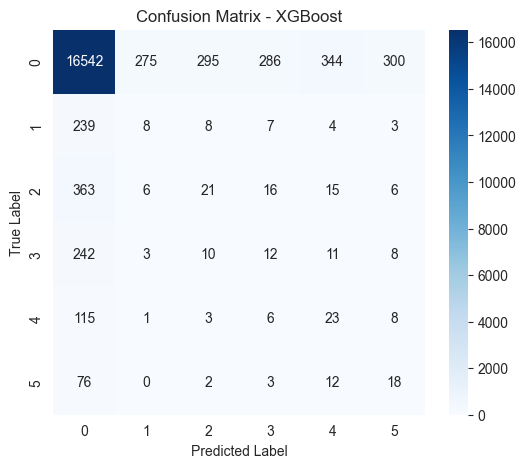

Training with 99.0% of data

Training XGBoost...


2025-04-08 17:34:11,838 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 4 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'num_class': 6, 'nthread': 1}
	train_call_kwargs_params: {'num_boost_round': 100, 'verbose_eval': True}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-04-08 17:34:17,830 INFO XGBoost-PySpark: _train_booster Training on CPUs 4]
[17:34:18] Task 2 got rank 2
[17:34:18] Task 1 got rank 1
[17:34:18] Task 0 got rank 0
[17:34:18] Task 3 got rank 3
2025-04-08 17:35:12,810 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2025-04-08 17:35:17,653 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-08 17:35:19,961 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-08 17:35:20,908 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-08 17:35:22,104 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-08 17:35:23,124 INFO XGBoost-PySpark: predict_udf Do the 


XGBoost (Data Size: 99.0%)
Accuracy: 0.8398
Precision: 0.8780
Recall: 0.8398
F1 Score: 0.8577
Training Time: 64.82 sec - Inference Latency: 0.15 sec
*Training* CPU: 50.56% | Memory: 89.63%
*Training* Disk Read: 496.83 MB | Write: 71.14 MB
*Inference* CPU: 3.00% | Memory: 89.40%
*Inference* Disk Read: 0.41 MB | Write: 0.00 MB


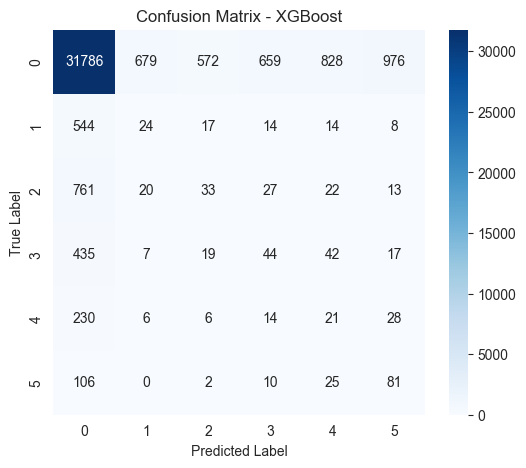

In [8]:
from pyspark.ml.linalg import Vectors

# Βελτίωση της απόδοσης του Spark:
# 1) Κατανομή των δεδομένων σε 20 partitions.
# 2) Αποθήκευση των δεδομένων στη μνήμη RAM.Αν ξαναχρειαστούμε τα δεδομένα δε θα διαβαστούν από το δίσκο.
row_count = final_data.count()
print(f"Το dataset αποτελείται από {row_count} γραμμές.")

final_data = final_data.repartition(20).cache()
final_data.count()  # Force materialization
print(f"final_data έχει {final_data.count()} γραμμές")

# Κλάση υπεύθυνη για την παρακολούθηση των τιμών των υπολογιστικών πόρων
monitor = ResourceMonitorListener()

# Διαφορετικά μεγέθη δεδομένων για scaling test
sizes = [0.1, 0.25, 0.5, 0.99] # 0.1, 0.25, 0.5, 0.99

for size in sizes:
    print(f"Training with {size * 100}% of data")

    # Εισαγωγή τυχαιότητας
    sub_sampled_data = final_data.sample(fraction=size, seed=42)
    if sub_sampled_data.isEmpty():
        print(f"No data sampled for size {size * 100}%. Skipping...")
        continue

    # Διαχωρισμός δεδομένων
    train_data, test_data = sub_sampled_data.randomSplit([0.8, 0.2], seed=42)

    # Μετατροπή δεδομένων σε Pandas DataFrame
    train_pandas = train_data.select("scaled_features", "LabelIndex").toPandas()

    # Μετατροπή των χαρακτηριστικών από VectorUDT σε NumPy array
    X = np.array(train_pandas["scaled_features"].apply(lambda x: np.array(x.toArray())).tolist())
    y = train_pandas["LabelIndex"].values

    # Εφαρμογή SMOTE
    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Μετατροπή σε PySpark DataFrame
    resampled_df = pd.DataFrame({"scaled_features": list(X_resampled), "LabelIndex": y_resampled})

    # Μετατροπή της στήλης "scaled_features" σε VectorUDT (απαίτηση του PySpark)
    resampled_df["scaled_features"] = resampled_df["scaled_features"].apply(lambda x: Vectors.dense(x))

    # Δημιουργία PySpark DataFrame
    train_data = spark.createDataFrame(resampled_df)

# Μοντέλα
    models = {
        #"Random Forest": RandomForestClassifier(labelCol="LabelIndex", featuresCol="scaled_features", numTrees=50, maxDepth=10), 
        "XGBoost": SparkXGBClassifier(label_col="LabelIndex", features_col="scaled_features", num_workers=4, use_gpu=False, num_boost_round=100),
    }

    # Αξιολόγηση
    evaluator_acc = MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="accuracy")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="f1")
    evaluator_precision = MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="weightedPrecision")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="weightedRecall")

    for name, model in models.items():
        print(f"\nTraining {name}...")

        monitor.start_monitoring()
        start_train = time.time()

        try:
            trained_model = model.fit(train_data)
        except Exception as e:
            print(f"Training failed: {e}")
            continue

        training_time = time.time() - start_train
        train_metrics = monitor.stop_monitoring()

        # Καθυστέρηση για σταθεροποίηση των μετρήσεων
        time.sleep(3)

        start_infer = time.time()
        monitor.start_monitoring()

        predictions = trained_model.transform(test_data)
        inference_latency = time.time() - start_infer
        infer_metrics = monitor.stop_monitoring()

        # Υπολογισμός μετρικών
        accuracy = evaluator_acc.evaluate(predictions)
        precision = evaluator_precision.evaluate(predictions)
        recall = evaluator_recall.evaluate(predictions)
        f1_score = evaluator_f1.evaluate(predictions)

        # Εκτύπωση αποτελεσμάτων
        print(f"\n{name} (Data Size: {size * 100}%)")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
        print(f"Training Time: {training_time:.2f} sec - Inference Latency: {inference_latency:.2f} sec")
        print(f"*Training* CPU: {train_metrics['cpu_usage']:.2f}% | Memory: {train_metrics['mem_usage']:.2f}%")
        print(f"*Training* Disk Read: {train_metrics['disk_read_mb']:.2f} MB | Write: {train_metrics['disk_write_mb']:.2f} MB")
        print(f"*Inference* CPU: {infer_metrics['cpu_usage']:.2f}% | Memory: {infer_metrics['mem_usage']:.2f}%")
        print(f"*Inference* Disk Read: {infer_metrics['disk_read_mb']:.2f} MB | Write: {infer_metrics['disk_write_mb']:.2f} MB")

        # Confusion matrices για Linear Regression και Random Forest
        if name in ["Logistic Regression", "Random Forest", "XGBoost"]:
            predictions_df = predictions.select("LabelIndex", "prediction").toPandas()
            cm = confusion_matrix(predictions_df["LabelIndex"], predictions_df["prediction"])

            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3, 4, 5], yticklabels=[0, 1, 2, 3, 4, 5])
            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            plt.title(f"Confusion Matrix - {name}")
            plt.show()

Το dataset αποτελείται από 193637 γραμμές.
final_data έχει 193637 γραμμές

Training with 10.0% of data

Training KNN...

KNN (Data Size: 10.0%)
Accuracy: 0.4733
Precision: 0.8678
Recall: 0.4733
F1 Score: 0.6061
Training Time: 0.01 sec - Inference Latency: 0.97 sec
*Training* CPU: 65.00% | Memory: 93.00%
*Training* Disk Read: 7.71 MB | Write: 0.00 MB
*Inference* CPU: 40.40% | Memory: 83.10%
*Inference* Disk Read: 0.00 MB | Write: 0.00 MB


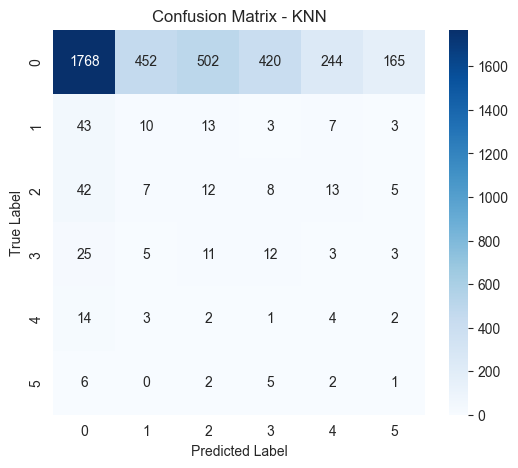


Training with 25.0% of data

Training KNN...

KNN (Data Size: 25.0%)
Accuracy: 0.5273
Precision: 0.8800
Recall: 0.5273
F1 Score: 0.6530
Training Time: 0.02 sec - Inference Latency: 8.07 sec
*Training* CPU: 2.90% | Memory: 83.60%
*Training* Disk Read: 0.02 MB | Write: 0.00 MB
*Inference* CPU: 43.39% | Memory: 83.60%
*Inference* Disk Read: 0.03 MB | Write: 0.02 MB


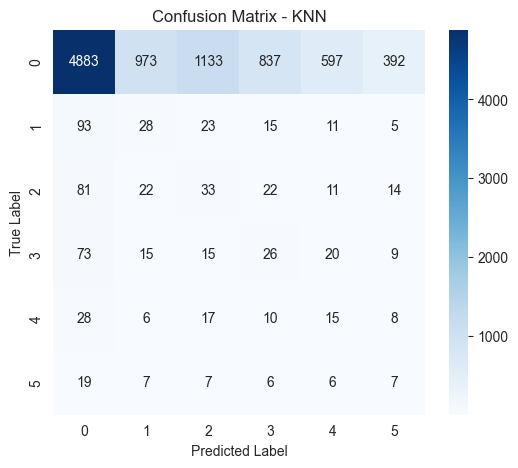


Training with 50.0% of data

Training KNN...

KNN (Data Size: 50.0%)
Accuracy: 0.5308
Precision: 0.8852
Recall: 0.5308
F1 Score: 0.6579
Training Time: 0.04 sec - Inference Latency: 27.77 sec
*Training* CPU: 31.80% | Memory: 84.00%
*Training* Disk Read: 4.32 MB | Write: 0.00 MB
*Inference* CPU: 52.23% | Memory: 83.91%
*Inference* Disk Read: 1.57 MB | Write: 31.34 MB


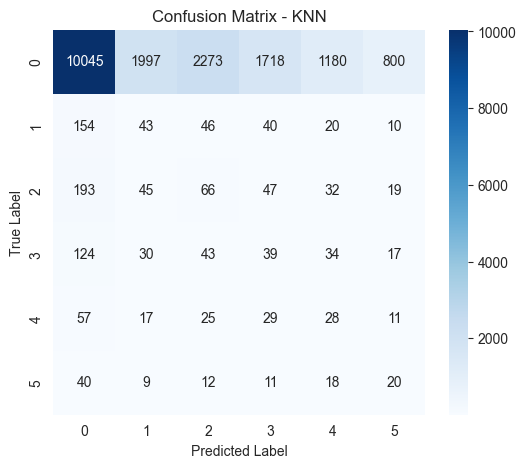


Training with 99.0% of data

Training KNN...

KNN (Data Size: 99.0%)
Accuracy: 0.5451
Precision: 0.8849
Recall: 0.5451
F1 Score: 0.6683
Training Time: 0.11 sec - Inference Latency: 106.60 sec
*Training* CPU: 7.30% | Memory: 85.20%
*Training* Disk Read: 0.00 MB | Write: 0.00 MB
*Inference* CPU: 53.70% | Memory: 85.41%
*Inference* Disk Read: 835.45 MB | Write: 0.81 MB


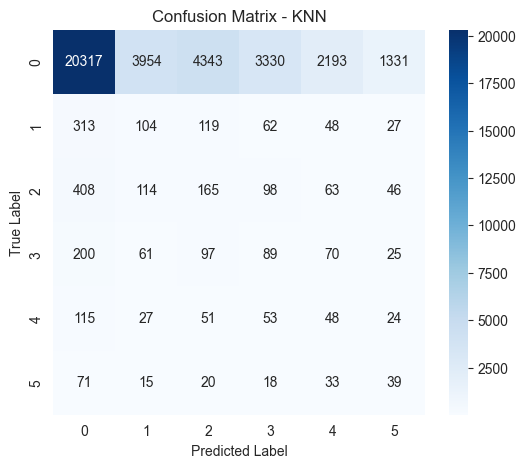

In [9]:
# Ξεχωριστό cell για το μοντέλο KNN, καθώς είναι διαφορετική η όλη διαδικασία για το συγκεκριμένο μοντέλο σε αντίθεση με τα προηγούμενα.

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

row_count = final_data.count()
print(f"Το dataset αποτελείται από {row_count} γραμμές.")

final_data = final_data.repartition(20).cache()
final_data.count()
print(f"final_data έχει {final_data.count()} γραμμές")

monitor = ResourceMonitorListener()

sizes = [0.1, 0.25, 0.5, 0.99] 

for size in sizes:
    print(f"\nTraining with {size * 100}% of data")

    sub_sampled_data = final_data.sample(fraction=size, seed=42)
    if sub_sampled_data.isEmpty():
        print(f"No data sampled for size {size * 100}%. Skipping...")
        continue

    train_data, test_data = sub_sampled_data.randomSplit([0.8, 0.2], seed=42)

    train_pandas = train_data.select("scaled_features", "LabelIndex").toPandas()
    test_pandas = test_data.select("scaled_features", "LabelIndex").toPandas()

    X_train = np.array(train_pandas["scaled_features"].apply(lambda x: np.array(x.toArray())).tolist())
    y_train = train_pandas["LabelIndex"].values

    X_test = np.array(test_pandas["scaled_features"].apply(lambda x: np.array(x.toArray())).tolist())
    y_test = test_pandas["LabelIndex"].values

    # SMOTE
    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Μοντέλα
    models = {
        "KNN": KNeighborsClassifier(n_neighbors=5, metric='euclidean')
    }

    for name, model in models.items():
        print(f"\nTraining {name}...")

        monitor.start_monitoring()
        start_train = time.time()

        try:
            model.fit(X_resampled, y_resampled)
        except Exception as e:
            print(f"Training failed: {e}")
            continue

        training_time = time.time() - start_train
        train_metrics = monitor.stop_monitoring()

        time.sleep(3)

        start_infer = time.time()
        monitor.start_monitoring()

        y_pred = model.predict(X_test)
        inference_latency = time.time() - start_infer
        infer_metrics = monitor.stop_monitoring()

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
        recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

        # Εκτύπωση αποτελεσμάτων
        print(f"\n{name} (Data Size: {size * 100}%)")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Training Time: {training_time:.2f} sec - Inference Latency: {inference_latency:.2f} sec")
        print(f"*Training* CPU: {train_metrics['cpu_usage']:.2f}% | Memory: {train_metrics['mem_usage']:.2f}%")
        print(f"*Training* Disk Read: {train_metrics['disk_read_mb']:.2f} MB | Write: {train_metrics['disk_write_mb']:.2f} MB")
        print(f"*Inference* CPU: {infer_metrics['cpu_usage']:.2f}% | Memory: {infer_metrics['mem_usage']:.2f}%")
        print(f"*Inference* Disk Read: {infer_metrics['disk_read_mb']:.2f} MB | Write: {infer_metrics['disk_write_mb']:.2f} MB")

        if name in ["KNN"]:
            predictions_df = pd.DataFrame({"LabelIndex": y_test, "prediction": y_pred})
            cm = confusion_matrix(predictions_df["LabelIndex"], predictions_df["prediction"])

            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3, 4, 5], yticklabels=[0, 1, 2, 3, 4, 5])
            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            plt.title(f"Confusion Matrix - {name}")
            plt.show()


Το dataset αποτελείται από 193637 γραμμές.
final_data έχει 193637 γραμμές
Training with 10.0% of data

Training LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 87024, number of used features: 20
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759

LightGBM (Data Size: 10.0%)
Accuracy: 0.8455
Precision: 0.8711
Recall: 0.8455
F1 Score: 0.8579
Training Time: 6.86 sec - Inference Latency: 0.06 sec
*Training* CPU: 91.80% | Memory: 85.20%
*Training* Disk Read: 3.49 MB | Write: 0.04 MB
*Inference* CPU: 6.6

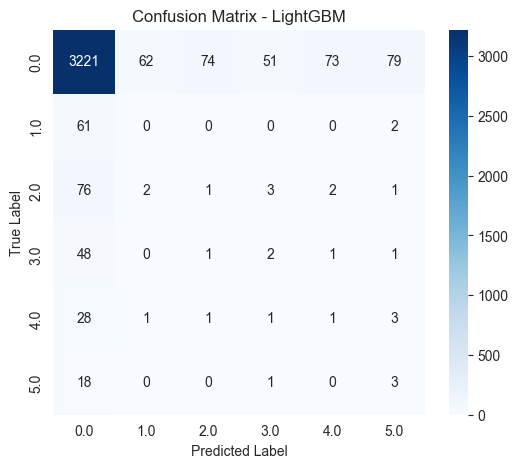

Training with 25.0% of data

Training LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 218316, number of used features: 20
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759

LightGBM (Data Size: 25.0%)
Accuracy: 0.8332
Precision: 0.8758
Recall: 0.8332
F1 Score: 0.8535
Training Time: 7.38 sec - Inference Latency: 0.20 sec
*Training* CPU: 89.50% | Memory: 85.60%
*Training* Disk Read: 0.05 MB | Write: 0.36 MB
*Inference* CPU: 22.70% | Memory: 85.60%
*Inference* Disk Read: 0.00 MB | Write: 0.05 MB


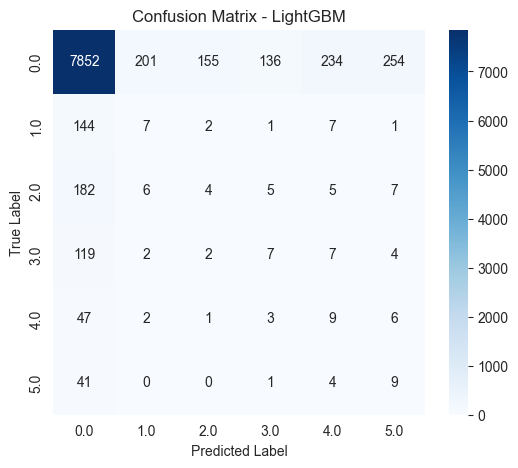

Training with 50.0% of data

Training LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 436398, number of used features: 20
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759

LightGBM (Data Size: 50.0%)
Accuracy: 0.8245
Precision: 0.8756
Recall: 0.8245
F1 Score: 0.8484
Training Time: 14.08 sec - Inference Latency: 0.23 sec
*Training* CPU: 90.98% | Memory: 86.80%
*Training* Disk Read: 4.36 MB | Write: 0.12 MB
*Inference* CPU: 24.50% | Memory: 85.80%
*Inference* Disk Read: 0.00 MB | Write: 0.32 MB


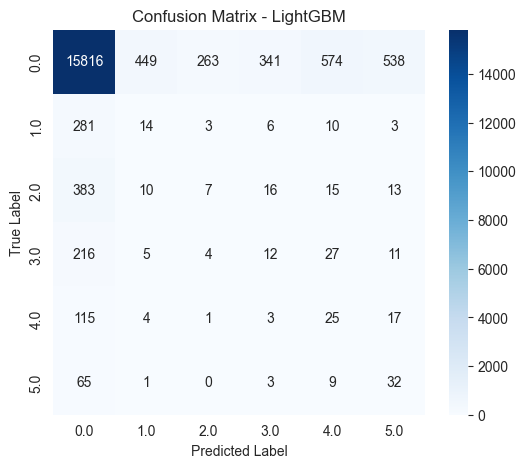

Training with 99.0% of data

Training LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 860220, number of used features: 20
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759

LightGBM (Data Size: 99.0%)
Accuracy: 0.8144
Precision: 0.8810
Recall: 0.8144
F1 Score: 0.8452
Training Time: 27.42 sec - Inference Latency: 0.37 sec
*Training* CPU: 94.51% | Memory: 88.59%
*Training* Disk Read: 17.14 MB | Write: 0.12 MB
*Inference* CPU: 35.00% | M

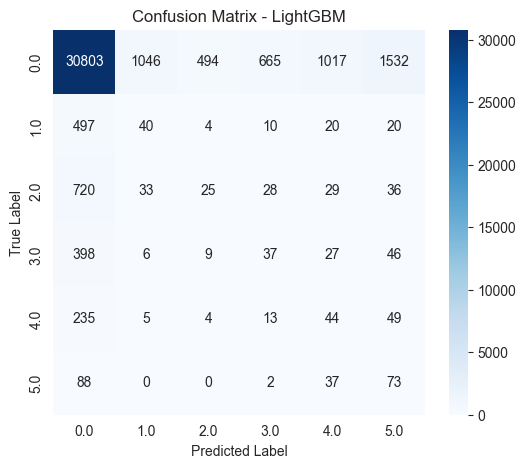

In [10]:
# Ξεχωριστό cell για το μοντέλο Light GBM, καθώς είναι διαφορετική η όλη διαδικασία για το συγκεκριμένο μοντέλο σε αντίθεση με τα προηγούμενα.

import lightgbm as lgb
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from pyspark.ml.linalg import Vectors
from sklearn.metrics import precision_score, recall_score, f1_score

row_count = final_data.count()
print(f"Το dataset αποτελείται από {row_count} γραμμές.")

final_data = final_data.repartition(20).cache()
final_data.count()  # Force materialization
print(f"final_data έχει {final_data.count()} γραμμές")

# Κλάση υπεύθυνη για την παρακολούθηση των τιμών των υπολογιστικών πόρων
monitor = ResourceMonitorListener()

# Διαφορετικά μεγέθη δεδομένων για scaling test
sizes = [0.1, 0.25, 0.5, 0.99]  

for size in sizes:
    print(f"Training with {size * 100}% of data")

    # Εισαγωγή τυχαιότητας
    sub_sampled_data = final_data.sample(fraction=size, seed=42)
    if sub_sampled_data.isEmpty():
        print(f"No data sampled for size {size * 100}%. Skipping...")
        continue

    # Διαχωρισμός δεδομένων
    train_data, test_data = sub_sampled_data.randomSplit([0.8, 0.2], seed=42)

    # Μετατροπή δεδομένων σε Pandas DataFrame
    train_pandas = train_data.select("scaled_features", "LabelIndex").toPandas()

    # Μετατροπή των χαρακτηριστικών από VectorUDT σε NumPy array
    X = np.array(train_pandas["scaled_features"].apply(lambda x: np.array(x.toArray())).tolist())
    y = train_pandas["LabelIndex"].values

    # Εφαρμογή SMOTE
    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Μετατροπή σε PySpark DataFrame
    resampled_df = pd.DataFrame({"scaled_features": list(X_resampled), "LabelIndex": y_resampled})

    # Μετατροπή της στήλης "scaled_features" σε VectorUDT (απαίτηση του PySpark)
    resampled_df["scaled_features"] = resampled_df["scaled_features"].apply(lambda x: Vectors.dense(x))

    # Δημιουργία PySpark DataFrame
    train_data = spark.createDataFrame(resampled_df)

    # Ετοιμασία των δεδομένων για LightGBM (σε NumPy arrays)
    X_train = np.array(resampled_df['scaled_features'].apply(lambda x: np.array(x.toArray())).tolist())
    y_train = np.array(resampled_df['LabelIndex'].values)

    # Δημιουργία LightGBM Dataset
    lgb_train = lgb.Dataset(X_train, label=y_train)

    # Ορισμός παραμέτρων για το LightGBM
    params = {
        'objective': 'multiclass',
        'num_class': len(np.unique(y)),  # Πολυκατηγορική ταξινόμηση
        'metric': 'multi_logloss',        # Πολυκατηγορική συνάρτηση κόστους
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9
    }

    # Εκπαίδευση του μοντέλου LightGBM
    print("\nTraining LightGBM model...")
    monitor.start_monitoring()
    start_train = time.time()

    # Εκπαίδευση LightGBM
    try:
        gbm = lgb.train(params, lgb_train, 100)
    except Exception as e:
        print(f"Training failed: {e}")
        continue

    training_time = time.time() - start_train
    train_metrics = monitor.stop_monitoring()

    # Καθυστέρηση για σταθεροποίηση των μετρήσεων
    time.sleep(3)

    # Πρόβλεψη με το μοντέλο
    X_test = np.array(test_data.select("scaled_features").toPandas()['scaled_features'].apply(lambda x: np.array(x.toArray())).tolist())
    y_test = np.array(test_data.select("LabelIndex").toPandas()['LabelIndex'])

    start_infer = time.time()
    monitor.start_monitoring()

    y_pred = gbm.predict(X_test)
    inference_latency = time.time() - start_infer
    infer_metrics = monitor.stop_monitoring()

    # Επιλογή της κατηγορίας με τη μέγιστη πιθανότητα
    y_pred_class = np.argmax(y_pred, axis=1)

    # Υπολογισμός μετρικών
    accuracy = np.mean(y_pred_class == y_test)
    precision = precision_score(y_test, y_pred_class, average="weighted", zero_division=0)
    recall = recall_score(y_test, y_pred_class, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred_class, average="weighted", zero_division=0)

    # Εκτύπωση αποτελεσμάτων
    print(f"\nLightGBM (Data Size: {size * 100}%)")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Training Time: {training_time:.2f} sec - Inference Latency: {inference_latency:.2f} sec")
    print(f"*Training* CPU: {train_metrics['cpu_usage']:.2f}% | Memory: {train_metrics['mem_usage']:.2f}%")
    print(f"*Training* Disk Read: {train_metrics['disk_read_mb']:.2f} MB | Write: {train_metrics['disk_write_mb']:.2f} MB")
    print(f"*Inference* CPU: {infer_metrics['cpu_usage']:.2f}% | Memory: {infer_metrics['mem_usage']:.2f}%")
    print(f"*Inference* Disk Read: {infer_metrics['disk_read_mb']:.2f} MB | Write: {infer_metrics['disk_write_mb']:.2f} MB")

    # Confusion matrices
    cm = confusion_matrix(y_test, y_pred_class)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - LightGBM")
    plt.show()
